In [18]:
# Importing dependencies
import pandas as pd
import matplotlib.pyplot as plt

In [19]:
# Reading CSV files to begin cleaning & merging
cab_ride=pd.read_csv("Cab-Weather-Data/cab_rides.csv")
weather_df=pd.read_csv("Cab-Weather-Data/weather.csv")

In [20]:
# Cleaning Weather Data
# The timestamps were listed in epoch formatting, and needs to be converted to a readable date format

weather_df["date"]=pd.to_datetime(weather_df["time_stamp"], unit="s")
weather_df["date"]=weather_df["date"].dt.strftime("%Y-%m-%d %H:%M")

# Moving columns into a more readable way
clean_weather_df=weather_df[["date","location","temp","clouds","pressure","rain","humidity","wind"]]

# Sorting our weather table in ascending order per date time
clean_weather_df = clean_weather_df.sort_values("date", ascending=True)

# Reset the index and change the location header to source. This is so our merge will align on common time point & weather conditions at pick up location
new_weather_df = clean_weather_df.reset_index(drop=True)
new_weather_df.rename(columns={"location":"source"}, inplace=True)
new_weather_df.head()

,date,source,temp,clouds,pressure,rain,humidity,wind
0,2018-11-26 03:40,Fenway,40.84,0.88,1014.35,NaN,0.93,1.31
1,2018-11-26 03:40,North End,41.02,0.87,1014.40,NaN,0.92,1.59
2,2018-11-26 03:40,Haymarket Square,40.98,0.87,1014.40,NaN,0.92,1.57
3,2018-11-26 03:40,Northeastern University,40.81,0.89,1014.35,NaN,0.93,1.36
4,2018-11-26 03:40,West End,40.84,0.87,1014.40,NaN,0.93,1.52


In [22]:
# Cleaning Car Ride Data
# The epoch timestamp in this table is represented in milliseconds, so we divide by 1000 to find the time in value of seconds
cab_ride["date"]=pd.to_datetime(cab_ride["time_stamp"]/1000, unit="s")


# Removing unwanted columns like id and product_id
clean_cab_df = cab_ride[["date","source","destination","distance","price","surge_multiplier","cab_type", "name"]]

# In order to align on the datetime format used in the weather data, we are using a function that changes it into YYYY-MM-DD H:M:S format
clean_cab_df["date"]=clean_cab_df["date"].dt.strftime("%Y-%m-%d %H:%M")
clean_cab_df = clean_cab_df.sort_values("date", ascending=True)

# Resetting the index
new_cab_df=clean_cab_df.reset_index(drop=True)
new_cab_df.head()


C:\Users\neera\AppData\Local\Temp\ipykernel_28132\2373127437.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_cab_df["date"]=clean_cab_df["date"].dt.strftime("%Y-%m-%d %H:%M")


,date,source,destination,distance,price,surge_multiplier,cab_type,name
0,2018-11-26 03:40,Northeastern University,Beacon Hill,2.43,10.5,1.00,Lyft,Lyft
1,2018-11-26 03:40,Theatre District,Fenway,2.66,16.0,1.00,Uber,UberXL
2,2018-11-26 03:40,Boston University,Financial District,4.46,62.5,1.75,Lyft,Lux Black
3,2018-11-26 03:40,Theatre District,Fenway,2.66,NaN,1.00,Uber,Taxi
4,2018-11-26 03:40,Fenway,Theatre District,2.66,NaN,1.00,Uber,Taxi


In [24]:
# Changing data type to ensure easy merging
new_cab_df["date"] = new_cab_df["date"].astype("datetime64[ns]")
print(new_cab_df.dtypes)

new_weather_df["date"]=new_weather_df["date"].astype("datetime64[ns]")
print(new_weather_df.dtypes)

date                datetime64[ns]
source                      object
destination                 object
distance                   float64
price                      float64
surge_multiplier           float64
cab_type                    object
name                        object
dtype: object
date        datetime64[ns]
source              object
temp               float64
clouds             float64
pressure           float64
rain               float64
humidity           float64
wind               float64
dtype: object


In [25]:
# Merging both dataframes on Date & Source. Left Join indicates that we only want to retain weather conditions for active rides

combined_df=pd.merge(new_cab_df,new_weather_df, on=["date","source"], how="left")
combined_df.head()

,date,source,destination,distance,price,surge_multiplier,cab_type,name,temp,clouds,pressure,rain,humidity,wind
0,2018-11-26 03:40:00,Northeastern University,Beacon Hill,2.43,10.5,1.00,Lyft,Lyft,40.81,0.89,1014.35,NaN,0.93,1.36
1,2018-11-26 03:40:00,Theatre District,Fenway,2.66,16.0,1.00,Uber,UberXL,40.80,0.87,1014.39,NaN,0.93,1.55
2,2018-11-26 03:40:00,Boston University,Financial District,4.46,62.5,1.75,Lyft,Lux Black,41.07,0.86,1014.39,NaN,0.92,1.36
3,2018-11-26 03:40:00,Theatre District,Fenway,2.66,NaN,1.00,Uber,Taxi,40.80,0.87,1014.39,NaN,0.93,1.55
4,2018-11-26 03:40:00,Fenway,Theatre District,2.66,NaN,1.00,Uber,Taxi,40.84,0.88,1014.35,NaN,0.93,1.31


In [27]:
# To ensure we have all rows that have weather conditions present, we want to drop all null values in the Temperature column
# Null values for rain or wind is ok because these are logical weather conditions

final_df=combined_df.dropna(subset=['temp'])
final_df=final_df.reset_index(drop=True)

# With the null values in other rows, we can fill them with "0"
final_df.fillna(0,inplace=True)
final_df.head()

,date,source,destination,distance,price,surge_multiplier,cab_type,name,temp,clouds,pressure,rain,humidity,wind
0,2018-11-26 03:40:00,Northeastern University,Beacon Hill,2.43,10.5,1.00,Lyft,Lyft,40.81,0.89,1014.35,0.0,0.93,1.36
1,2018-11-26 03:40:00,Theatre District,Fenway,2.66,16.0,1.00,Uber,UberXL,40.80,0.87,1014.39,0.0,0.93,1.55
2,2018-11-26 03:40:00,Boston University,Financial District,4.46,62.5,1.75,Lyft,Lux Black,41.07,0.86,1014.39,0.0,0.92,1.36
3,2018-11-26 03:40:00,Theatre District,Fenway,2.66,0.0,1.00,Uber,Taxi,40.80,0.87,1014.39,0.0,0.93,1.55
4,2018-11-26 03:40:00,Fenway,Theatre District,2.66,0.0,1.00,Uber,Taxi,40.84,0.88,1014.35,0.0,0.93,1.31


In [28]:
# Adding the day of the week to our table to see if that may have any correlation to weather
final_df["day of week"]=final_df["date"].dt.day_name()
final_df.head()

,date,source,destination,distance,price,surge_multiplier,cab_type,name,temp,clouds,pressure,rain,humidity,wind,day of week
0,2018-11-26 03:40:00,Northeastern University,Beacon Hill,2.43,10.5,1.00,Lyft,Lyft,40.81,0.89,1014.35,0.0,0.93,1.36,Monday
1,2018-11-26 03:40:00,Theatre District,Fenway,2.66,16.0,1.00,Uber,UberXL,40.80,0.87,1014.39,0.0,0.93,1.55,Monday
2,2018-11-26 03:40:00,Boston University,Financial District,4.46,62.5,1.75,Lyft,Lux Black,41.07,0.86,1014.39,0.0,0.92,1.36,Monday
3,2018-11-26 03:40:00,Theatre District,Fenway,2.66,0.0,1.00,Uber,Taxi,40.80,0.87,1014.39,0.0,0.93,1.55,Monday
4,2018-11-26 03:40:00,Fenway,Theatre District,2.66,0.0,1.00,Uber,Taxi,40.84,0.88,1014.35,0.0,0.93,1.31,Monday


In [29]:
# Formatting some columns to show accurate values
final_df["clouds"]=final_df["clouds"]*100
final_df["humidity"]=final_df["humidity"]*100

In [30]:
# Pretty-fying our final dataframe by including units of measurement for easy analysis

final_df = final_df.rename(columns={"date":"Date","day of week":"Weekday","source":"Pick Up Location","destination":"Destination",
                                    "distance":"Distance (m)","price":"Price ($)","surge_multiplier":"Surge Multiplier",
                                    "cab_type":"Rideshare App","name":"Ride Type","temp":"Temp (C)",
                                    "clouds":"Cloudiness (%)","pressure":"Pressure (MB)","rain":"Rainfall (in)",
                                    "humidity":"Humidity (%)","wind":"Wind Speed (mph)"})

final_df = final_df[["Date","Weekday","Pick Up Location","Destination","Distance (m)","Price ($)","Surge Multiplier","Rideshare App","Ride Type",
                     "Temp (C)","Cloudiness (%)","Pressure (MB)","Rainfall (in)","Humidity (%)","Wind Speed (mph)"]]
final_df.head()

,Date,Weekday,Pick Up Location,Destination,Distance (m),Price ($),Surge Multiplier,Rideshare App,Ride Type,Temp (C),Cloudiness (%),Pressure (MB),Rainfall (in),Humidity (%),Wind Speed (mph)
0,2018-11-26 03:40:00,Monday,Northeastern University,Beacon Hill,2.43,10.5,1.00,Lyft,Lyft,40.81,89.0,1014.35,0.0,93.0,1.36
1,2018-11-26 03:40:00,Monday,Theatre District,Fenway,2.66,16.0,1.00,Uber,UberXL,40.80,87.0,1014.39,0.0,93.0,1.55
2,2018-11-26 03:40:00,Monday,Boston University,Financial District,4.46,62.5,1.75,Lyft,Lux Black,41.07,86.0,1014.39,0.0,92.0,1.36
3,2018-11-26 03:40:00,Monday,Theatre District,Fenway,2.66,0.0,1.00,Uber,Taxi,40.80,87.0,1014.39,0.0,93.0,1.55
4,2018-11-26 03:40:00,Monday,Fenway,Theatre District,2.66,0.0,1.00,Uber,Taxi,40.84,88.0,1014.35,0.0,93.0,1.31


In [31]:
# Sending this dataframe into a csv file to analyze further

final_df.to_csv("rideshare_vs_weather.csv", index=False)

In [32]:
final_df.head()

,Date,Weekday,Pick Up Location,Destination,Distance (m),Price ($),Surge Multiplier,Rideshare App,Ride Type,Temp (C),Cloudiness (%),Pressure (MB),Rainfall (in),Humidity (%),Wind Speed (mph)
0,2018-11-26 03:40:00,Monday,Northeastern University,Beacon Hill,2.43,10.5,1.00,Lyft,Lyft,40.81,89.0,1014.35,0.0,93.0,1.36
1,2018-11-26 03:40:00,Monday,Theatre District,Fenway,2.66,16.0,1.00,Uber,UberXL,40.80,87.0,1014.39,0.0,93.0,1.55
2,2018-11-26 03:40:00,Monday,Boston University,Financial District,4.46,62.5,1.75,Lyft,Lux Black,41.07,86.0,1014.39,0.0,92.0,1.36
3,2018-11-26 03:40:00,Monday,Theatre District,Fenway,2.66,0.0,1.00,Uber,Taxi,40.80,87.0,1014.39,0.0,93.0,1.55
4,2018-11-26 03:40:00,Monday,Fenway,Theatre District,2.66,0.0,1.00,Uber,Taxi,40.84,88.0,1014.35,0.0,93.0,1.31


In [33]:
revenue_df=final_df.groupby("Rideshare App")["Price ($)"].sum()

revenue_df

Rideshare App
Lyft    491174.0
Uber    483412.0
Name: Price ($), dtype: float64

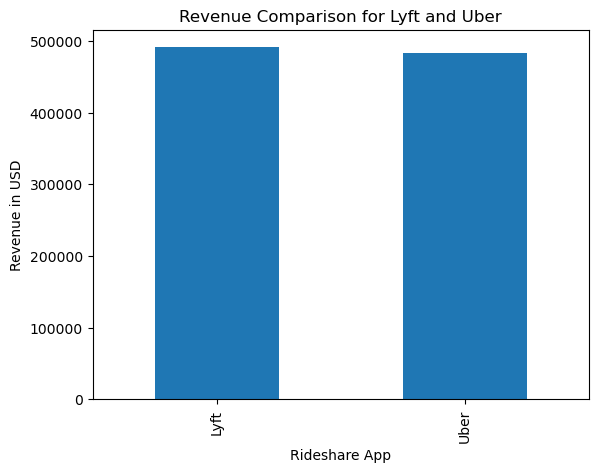

In [34]:
revenue_df.plot(kind='bar')
plt.title("Revenue Comparison for Lyft and Uber")
plt.xlabel("Rideshare App")
plt.ylabel("Revenue in USD")
plt.show()

In [35]:
final_df["month"] = final_df['Date'].dt.month
final_df.head()

,Date,Weekday,Pick Up Location,Destination,Distance (m),Price ($),Surge Multiplier,Rideshare App,Ride Type,Temp (C),Cloudiness (%),Pressure (MB),Rainfall (in),Humidity (%),Wind Speed (mph),month
0,2018-11-26 03:40:00,Monday,Northeastern University,Beacon Hill,2.43,10.5,1.00,Lyft,Lyft,40.81,89.0,1014.35,0.0,93.0,1.36,11
1,2018-11-26 03:40:00,Monday,Theatre District,Fenway,2.66,16.0,1.00,Uber,UberXL,40.80,87.0,1014.39,0.0,93.0,1.55,11
2,2018-11-26 03:40:00,Monday,Boston University,Financial District,4.46,62.5,1.75,Lyft,Lux Black,41.07,86.0,1014.39,0.0,92.0,1.36,11
3,2018-11-26 03:40:00,Monday,Theatre District,Fenway,2.66,0.0,1.00,Uber,Taxi,40.80,87.0,1014.39,0.0,93.0,1.55,11
4,2018-11-26 03:40:00,Monday,Fenway,Theatre District,2.66,0.0,1.00,Uber,Taxi,40.84,88.0,1014.35,0.0,93.0,1.31,11


In [36]:
lyft=final_df[final_df["Rideshare App"]=="Lyft"]
lyft_monthly_rev=lyft.groupby(["month"])["Price ($)"].sum()
lyft_monthly_rev

uber=final_df[final_df["Rideshare App"]=="Uber"]
uber_monthly_rev=uber.groupby(["month"])["Price ($)"].sum()
uber_monthly_rev


month
11    280773.0
12    202639.0
Name: Price ($), dtype: float64

In [37]:
monthly_rev_df=pd.DataFrame({"Lyft":lyft_monthly_rev,"Uber":uber_monthly_rev})

monthly_rev_df

,Lyft,Uber
month,,
11,280288.0,280773.0
12,210886.0,202639.0


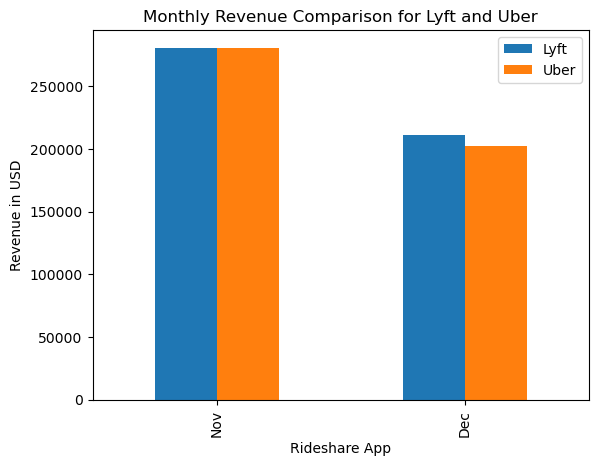

In [40]:
ax=monthly_rev_df.plot.bar()
labels=['Nov','Dec']
ax.set_xticklabels(labels)
plt.title("Monthly Revenue Comparison for Lyft and Uber")
plt.xlabel("Rideshare App")
plt.ylabel("Revenue in USD")
plt.show()